# Baseline Code

## 라이브러리 불러오기

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 데이터 받아오기

In [9]:
def load_chat_data(filepath):
    df = pd.read_csv(filepath)
    
    labels = df.iloc[:, 1].astype(str).tolist()
    sentences = df.iloc[:, 2].astype(str).tolist()

    return labels, sentences

In [11]:
original_train_data_path ="../data/original_data/original_train.csv"
# 아래 경로는 예시입니다.
augmented_train_data_path ="../data/augmentation_data/augmentation_train.csv"
general_train_data_path ="../data/general_data/general_train.csv"

labels, sentences = load_chat_data(original_train_data_path)
print("질문 예시:", labels[:1])
print("답변 예시:", sentences[:1])

질문 예시: ['협박 대화']
답변 예시: ['지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해? 진짜 죽여버리고 싶게.\n 정말 잘못했습니다.\n 너가 선택해. 너가 죽을래 네 가족을 죽여줄까.\n 죄송합니다. 정말 잘못했습니다.\n 너에게는 선택권이 없어. 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야.\n 선택 못하겠습니다. 한번만 도와주세요.\n 그냥 다 죽여버려야겠군. 이의 없지?\n 제발 도와주세요.']


## 데이터 전처리

### 데이터 전처리 함수 불러와서 사용

In [13]:
from .preprocessing.vanila_preprocess import *

example = "와!진짜대박123진짜"
print(preprocess_sentence(example))

와 ! 진짜대박 123 진짜


In [14]:
sentences = [preprocess_sentence(s) for s in sentences]
print("대화 예시:", sentences[7])

문장 예시: 경비아저씨 내차에 경고장 붙였어요 ? 내가 여기 몇년째 사는데 아직도 내차인줄 모르고 이딴식으로 경고장을 붙여 ? 입주민께서 정해진 주차자리가 아닌 통로에 계속 주차하셔서 입주민들 항의가 계속 들어옵니다 . 내가 항상 대는 거기 자리가 없으니까 그렇지 . 내차 이거 어떻게 할거요 ? 얼마짜린줄 알아 ? 수차례 인터폰도 드렸고 경고장을 올렸으나 몇일째 그대로 인지라 아파트규약에 맞춰 어쩔수 없었습니다 그렇다고 본드로 붙이면 어떻게 ? 당장 이거 깨끗히 원상복구시키고 세차해와 그럴 수는 없습니다 . 내가 낸 관리비로 월급받는 주제에 뭐라는거야 ? 안붙혔으면 되잖아 . 나 지금 거기 가요 ! 말씀이 과하신거 아닙니까 ? 딱 기다려요 이름뭐죠 ? 나 지금 가면 당신 이제 끝이야


### 단어장 만들기 & 정수 인코딩

In [25]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences, target_vocab_size=2**13)
print("슝=3 ")

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 


In [26]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [27]:
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8031


### 정수 인코딩

In [28]:
# 정수 인코딩
def tokenize(sentences):
    
    tokenized_sentences = []
  
    for sentence in sentences:
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence = START_TOKEN + tokenizer.encode(sentence) + END_TOKEN
        tokenized_sentences.append(sentence)
  
    return tokenized_sentences

tokenized_sentences = tokenize(sentences)

### 데이터 확인

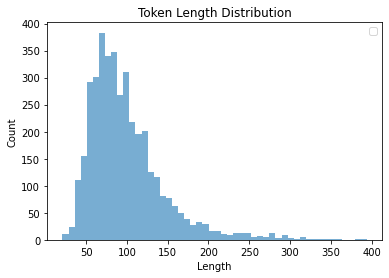

In [30]:
sentence_lengths = [len(s) for s in tokenized_sentences]

plt.hist(sentence_lengths, bins=50, alpha=0.6)
plt.xlabel('Length')
plt.ylabel('Count')
plt.title('Token Length Distribution')
plt.legend()
plt.show()

In [31]:
print("질문 최대 길이:", np.max(sentence_lengths))

print("95% 답변 길이:", np.percentile(sentence_lengths, 95))

질문 최대 길이: 394
95% 답변 길이: 190.0


In [42]:
MAX_LENGTH = 200

# 최대 길이를 초과하는 샘플 제거, 패딩
def filter(sentences, labels):
    filtered_sentences, filtered_labels = [], []
  
    for sentence, label in zip(sentences, labels):
    # 최대 길이 15 이하인 경우에만 데이터셋으로 허용
        if len(sentence) <= MAX_LENGTH:
            filtered_sentences.append(sentence)
            filtered_labels.append(label)
  
  # 최대 길이 15로 모든 데이터셋을 패딩
    filtered_sentences = tf.keras.preprocessing.sequence.pad_sequences(
        filtered_sentences, maxlen=MAX_LENGTH, padding='post')
  
    return filtered_sentences, filtered_labels

sentences, labels = filter(tokenized_sentences, labels)

In [35]:
print('필터링&패딩 후의 21번째 샘플: {}'.format(sentences[21]))

필터링&패딩 후의 21번째 샘플: [8029   28 3283  597  173  667 1169  239  704 2609 1691   20 1773   55
  206 2377  464  175 4155  149 1599   20 2579 1162   15    4 1760 6234
 1077  665   47  360 7683   17    5    5 5126  123 2679  904 7676  142
 2042 2130  223 4564   15 1252    2  213 8009 7946 7909 8009 7946 7909
 7805 7217  500  459 2757   22    2   14  113 7079 7805    6 5000   16
   58  931 1260 2368  351 8030    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0   

In [36]:
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 샘플 개수: {}'.format(len(sentences)))

단어장의 크기 : 8031
필터링 후의 샘플 개수: 3795


### 레이블 원-핫 인코딩

In [43]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# 1. LabelEncoder로 정수 인코딩
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)

# 2. One-hot 인코딩
onehot_labels = to_categorical(integer_encoded)

print(onehot_labels[:3])

[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


### 데이터셋 구성

In [45]:
from sklearn.model_selection import train_test_split

# 문장과 레이블을 train/val로 나누기
sent_train, sent_val, label_train, label_val = train_test_split(
    sentences, onehot_labels, test_size=0.2, random_state=42, stratify=onehot_labels
)

In [46]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

train_dataset = tf.data.Dataset.from_tensor_slices((sent_train, label_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((sent_val, label_val))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## 모델 구성

In [52]:
from .models.vanila_model import *

# 하이퍼파라미터 정의
# 클래스 개수는 일반 대화가 있는 경우 5로 사용
NUM_CLASSES = 4

model = create_transformer_classifier(
    vocab_size=VOCAB_SIZE,
    maxlen=MAX_LENGTH,
    embed_dim=128,
    num_heads=4,
    ff_dim=256,
    num_classes=NUM_CLASSES
)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 200, 128)          1027968   
_________________________________________________________________
transformer_block_3 (Transfo (None, 200, 128)          330240    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 128)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0   

## 모델 학습

In [53]:
model.fit(train_dataset, validation_data=val_dataset, epochs=5)

Epoch 1/5
48/48 [==============================] - 3s 37ms/step - loss: 1.3954 - accuracy: 0.2925 - val_loss: 1.3440 - val_accuracy: 0.3030
Epoch 2/5
48/48 [==============================] - 2s 32ms/step - loss: 1.0162 - accuracy: 0.5626 - val_loss: 0.4919 - val_accuracy: 0.8195
Epoch 3/5
48/48 [==============================] - 2s 32ms/step - loss: 0.2250 - accuracy: 0.9305 - val_loss: 0.3794 - val_accuracy: 0.8762
Epoch 4/5
48/48 [==============================] - 2s 32ms/step - loss: 0.0420 - accuracy: 0.9904 - val_loss: 0.6028 - val_accuracy: 0.8445
Epoch 5/5
48/48 [==============================] - 2s 32ms/step - loss: 0.0135 - accuracy: 0.9967 - val_loss: 0.5856 - val_accuracy: 0.8656


## 테스트

### 테스트 데이터 로드

In [54]:
test_df = pd.read_csv('../data/original_data/test.csv')

In [55]:
test_sentences = test_df['text'].apply(preprocess_sentence)

# 토크나이저로 정수 인코딩
# (train 때 사용한 tokenizer를 그대로 사용해야 함)
test_sentences = tokenize(test_sentences)

test_sentences = tf.keras.preprocessing.sequence.pad_sequences(
    test_sentences, maxlen=MAX_LENGTH, padding='post')

In [57]:
pred_probs = model.predict(test_sentences)  # shape: (num_samples, num_classes)
pred_classes = pred_probs.argmax(axis=1)  # 정수 인덱스 예측

In [58]:
pred_labels = label_encoder.inverse_transform(pred_classes)

In [62]:
test_df['predicted_label'] = pred_labels
test_df.to_csv('../data/results/test_predictions.csv', index=False)

In [63]:
test_df.head()

,idx,text,predicted_label
0,t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...,협박 대화
1,t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...,직장 내 괴롭힘 대화
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...,직장 내 괴롭힘 대화
3,t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...,직장 내 괴롭힘 대화
4,t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...,직장 내 괴롭힘 대화
